In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

import shap

In [ ]:
df = pd.read_csv("/content/healthcare_dataset.csv")
print(df.shape)
df.head()


(55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [ ]:
# Drop irrelevant columns
df = df.drop(['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Insurance Provider'], axis=1)

# Handle missing values
df = df.fillna(method='ffill')

# Create KPI features
np.random.seed(42)
df['LOS'] = np.random.randint(1, 11, size=len(df))  # Length of Stay (1-10 days)
df['Weekend_Admission'] = np.random.randint(0, 2, size=len(df))  # 0 or 1

# Synthetic target: readmitted
df['readmitted'] = np.random.choice([0,1], size=len(df), p=[0.65, 0.35])

df.head()


/tmp/ipython-input-3-2721511070.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Age,Gender,Blood Type,Medical Condition,Billing Amount,Admission Type,Medication,Test Results,LOS,Weekend_Admission,readmitted
0,30,Male,B-,Cancer,18856.281306,Urgent,Paracetamol,Normal,7,0,1
1,62,Male,A+,Obesity,33643.327287,Emergency,Ibuprofen,Inconclusive,4,0,0
2,76,Female,A-,Obesity,27955.096079,Emergency,Aspirin,Normal,8,1,1
3,28,Female,O+,Diabetes,37909.782410,Elective,Ibuprofen,Abnormal,5,0,1
4,43,Female,AB+,Cancer,14238.317814,Urgent,Penicillin,Abnormal,7,1,0


/tmp/ipython-input-4-273033245.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='LOS', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Blues_d')
/tmp/ipython-input-4-273033245.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LOS', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Blues_d')


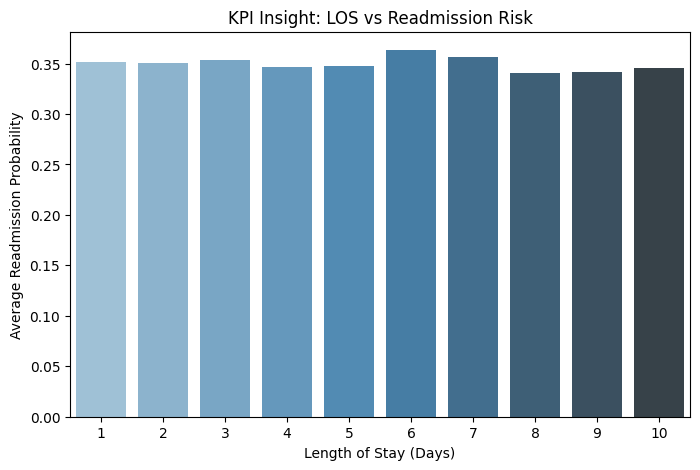

/tmp/ipython-input-4-273033245.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Weekend_Admission', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Oranges_d')
/tmp/ipython-input-4-273033245.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weekend_Admission', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Oranges_d')


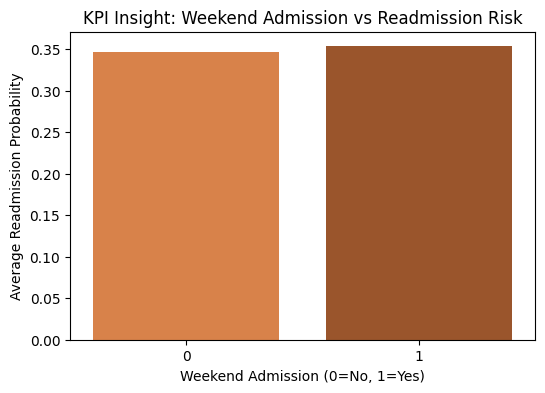

In [ ]:

# 1. LOS vs Readmission Risk
plt.figure(figsize=(8,5))
sns.barplot(x='LOS', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Blues_d')
plt.title("KPI Insight: LOS vs Readmission Risk")
plt.ylabel("Average Readmission Probability")
plt.xlabel("Length of Stay (Days)")
plt.show()

# 2. Weekend Admission vs Readmission Risk
plt.figure(figsize=(6,4))
sns.barplot(x='Weekend_Admission', y='readmitted', data=df, estimator=np.mean, ci=None, palette='Oranges_d')
plt.title("KPI Insight: Weekend Admission vs Readmission Risk")
plt.ylabel("Average Readmission Probability")
plt.xlabel("Weekend Admission (0=No, 1=Yes)")
plt.show()


In [ ]:
# Separate features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Categorical & numerical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])


In [ ]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = {}

df = pd.read_csv("/content/healthcare_dataset.csv")

# Drop irrelevant columns
df = df.drop(['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Insurance Provider'], axis=1)

# Handle missing values
df = df.fillna(method='ffill')

# Create KPI features
np.random.seed(42)
df['LOS'] = np.random.randint(1, 11, size=len(df))  # Length of Stay (1-10 days)
df['Weekend_Admission'] = np.random.randint(0, 2, size=len(df))  # 0 or 1

# Synthetic target: readmitted
df['readmitted'] = np.random.choice([0,1], size=len(df), p=[0.65, 0.35])


# Separate features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Categorical & numerical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

for name, model in models.items():
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}")

/tmp/ipython-input-7-656795319.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


RandomForest Accuracy: 0.62
LogisticRegression Accuracy: 0.65
SVM Accuracy: 0.65
[LightGBM] [Info] Number of positive: 15526, number of negative: 28874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 44400, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349685 -> initscore=-0.620425
[LightGBM] [Info] Start training from score -0.620425
LightGBM Accuracy: 0.65


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
plt.bar(results.keys(), results.values(), color=['blue','green','orange','red'])
plt.title("Model Comparison - Accuracy")
plt.ylabel("Accuracy")
plt.show()


NameError: name 'plt' is not defined